<a href="https://colab.research.google.com/github/yewonlee5/yewonlee5.github.io/blob/main/A_B_Testing_and_Causal_Inference_Analysis_Weather_Based_Product_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A/B Testing and Causal Inference Analysis**: Measuring the Effect of Weather-Based Product Recommendations on User Engagement

## 1. Business Context and Objective

Let’s say you’re a huge fan of a K-pop artist. It’s a rainy afternoon, and you receive a push notification from a mobile app that says:

> _“Rainy days always remind me of this moment 🌧️ — check out this clip from [Your Favorite Artist]!”_

You tap the notification, and the video turns out to be your favorite artist talking about their favorite rainy-day memory. You watch it. Maybe you even watch it twice.

Now, let’s rewind. Imagine you received a **random** notification at that same time. Something like:

> _“This videos are trending! Don’t miss out 🎥”_

Would your response be the same? Would you have watched it as long? Would you have clicked at all?

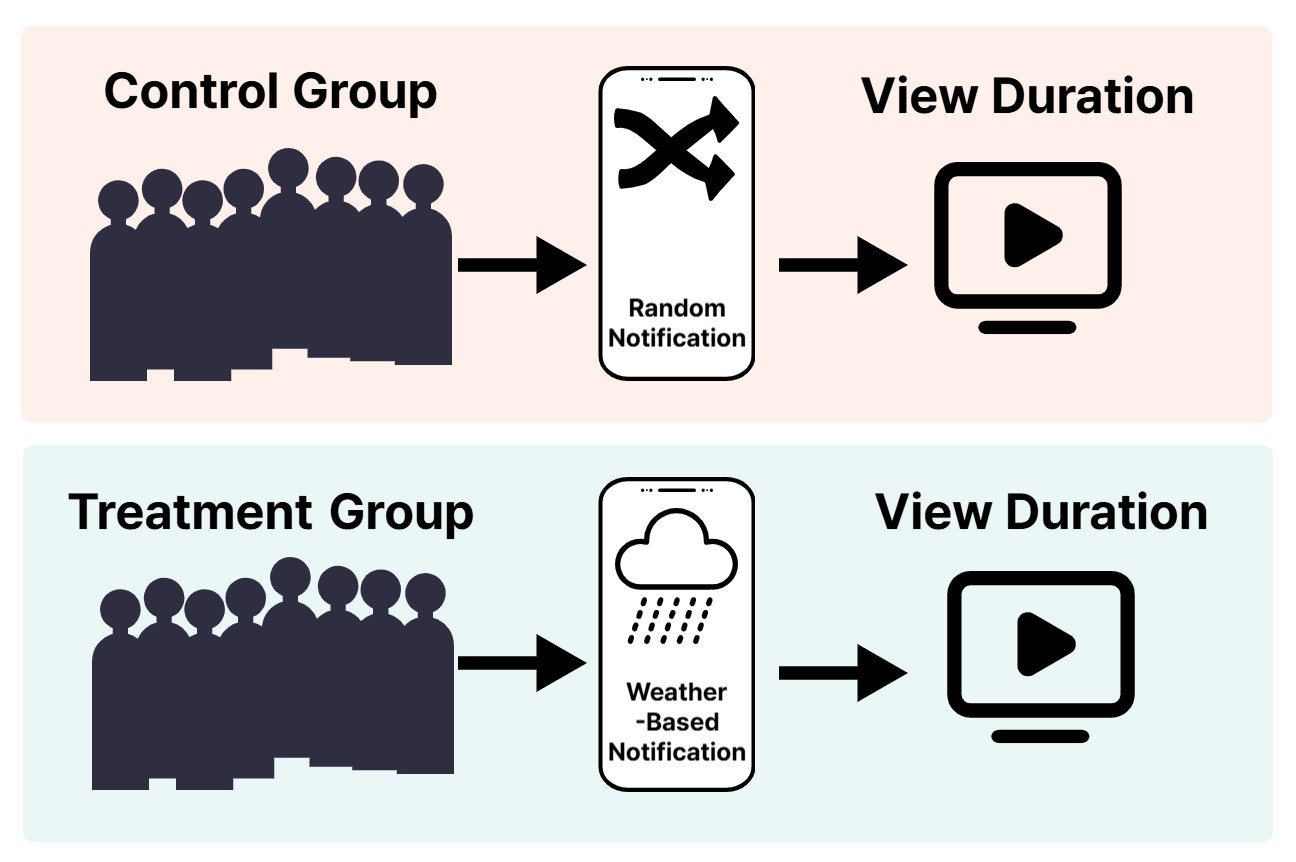

This is the business question we're exploring:

> **Does product recommendation notifications based on current weather conditions increase user engagement, compared to sending generic/random notifications?**

The mobile app platform in question is built by a K-pop entertainment company. Think of it as a hybrid between Instagram and TikTok, but with only K-pop artists as content creators.

The platform includes:
- Artist-generated videos, livestreams, and stories
- In-app purchases of artist merchandise and exclusive content
- Subscription-based fan memberships
- Direct artist-to-fan messaging and interactions

### Why This Matters

Push notifications are one of the most powerful tools for driving engagement in mobile platforms. But **relevance** is key. If a notification feels timely, personal, or emotionally resonant, it might lead to deeper engagement — in this case, measured as **view duration** (how long the user watches the recommended content).

Let's assume that we have proposed a new **weather-based notification system**, where content recommendations are tied to local weather conditions — sunny day stories, rainy day clips, cozy winter scenes, etc.

To evaluate its effectiveness, we run an A/B test, comparing a group of users receiving the weather-based notifications (treatment group) to a group that receives random notifications (control group). If the treatment group shows higher engagement, that’s a promising sign — but it’s not the whole story.

Even if we observe a difference in view duration between the two groups, we must be cautious before attributing that difference solely to the new system. Correlation does not imply causation. External factors — such as time of day, user demographics, or even the type of content trending at the moment — could influence both the exposure to weather-based notifications and engagement levels.

That’s why causal inference is critical. A/B testing gives us the experimental framework, but proper causal analysis ensures that we isolate the effect of the weather-based notifications themselves, accounting for potential confounders and ruling out alternative explanations.

### Core Goals
1. **Evaluate whether weather-based notifications increase user engagement.** (Success metrics: view duration)
2. **Determine if the effect is truly causal**, or if other factors (e.g., the content itself) are influencing user behavior.

To answer these questions, we’ll simulate an experiment using two groups:
- **Control group**: Receives random product recommendation notifications.
- **Treatment group**: Receives personalized weather-based notifications.

We’ll use:
- A/B testing to evaluate whether there’s a statistically significant difference in engagement.
- Causal inference technique (propensity score matching) to assess whether the observed difference is **because of the treatment** — or **due to a confounding variable**.



---


## 2. Simulating Pre-Treatment Data

To prepare for our experiment, we collect weather dataset using Weather API and simulate a realistic dataset that captures user behavior and product (content) context **before** applying any treatment.

### Purpose

- Create a baseline dataset to reflect how users engage **organically**
- Capture **covariates** (user/product/weather) for later A/B testing and causal analysis
- Set up a structure suitable for **RCT (Randomized Controlled Trials) simulation**

1. Weather API
- `date`
- `max_temp`
- `min_temp`
- `avg_temp`
- `condition` (e.g., Sunny, Cloudy, Rainy)
- `precipitation`

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import requests
from datetime import datetime, timedelta

# API key from weatherapi.com
api_key_path = "/content/drive/MyDrive/weather_ci/weather_api_key.txt"
with open(api_key_path, 'r') as file:
    API_KEY = file.read().strip()

BASE_URL = "https://api.weatherapi.com/v1/history.json"

# Function to get weather data for a specific date
def get_weather_data(date, location):
    params = {
        "key": API_KEY,
        "q": location,
        "dt": date
    }

    response = requests.get(BASE_URL, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching data for {date}: {response.status_code}")
        return None

# Function to get weather data for the past year
def get_weather_for_last_year(location):
    # Get today's date and calculate the last year's range
    today = datetime.today()
    one_year_ago = today - timedelta(days=365)

    current_date = today

    # Collect weather data for each day in the past year
    weather_data = []

    while current_date >= one_year_ago:
        date_str = current_date.strftime('%Y-%m-%d')
        data = get_weather_data(date_str, location)

        if data:
            # Extract relevant data (temperature, condition, precipitation)
            day_data = data.get("forecast", {}).get("forecastday", [])[0].get("day", {})

            weather_info = {
                "date": date_str,
                "max_temp": day_data.get("maxtemp_c"),
                "min_temp": day_data.get("mintemp_c"),
                "avg_temp": day_data.get("avgtemp_c"),
                "condition": day_data.get("condition", {}).get("text"),
                "precipitation": day_data.get("totalprecip_mm"),
            }

            weather_data.append(weather_info)

        # Move to the previous day
        current_date -= timedelta(days=1)

    return weather_data

if __name__ == "__main__":
    location = "New York"
    weather_data = get_weather_for_last_year(location)

    df_list = []
    # results
    for data in weather_data:
        df_list.append(data)

In [ ]:
import pandas as pd

weather_df = pd.DataFrame(df_list)

In [ ]:
print(weather_df['date'].min())
print(weather_df['date'].max())

2024-04-10
2025-04-10


In [ ]:
list(weather_df.condition.unique())

['Overcast',
 'Sunny',
 'Cloudy',
 'Moderate or heavy rain shower',
 'Patchy rain possible',
 'Moderate rain at times',
 'Light rain shower',
 'Partly cloudy',
 'Light freezing rain',
 'Patchy moderate snow',
 'Heavy rain at times',
 'Moderate or heavy snow showers',
 'Moderate rain',
 'Moderate snow',
 'Fog']

2. Product table
- `product_id`
- `product_released_date`
- `product_feature` (Rain / Sunny / Snow / N/A)

In [ ]:
weather_choice = ['Rain', 'Sunny', 'Snow', 'N/A']
probabilities = [0.10, 0.10, 0.10, 0.70]

In [ ]:
import numpy as np
from datetime import datetime, timedelta

# Set a random seed for reproducibility
np.random.seed(20250407)

# Number of users, views, and products
num_users_before = 1000
num_users_added = 1000
num_views_before = 5000
num_views_after = 10000
num_products = 500

In [ ]:
def generate_product_features(num_products):
    products = []

    for product_id in range(1, num_products + 1):
        # Random release date in the past 2 years
        release_date = datetime.today() - timedelta(days=np.random.randint(1, 365*2+1))
        # Random weather-related feature (one of the weather conditions)
        product_feature = np.random.choice(weather_choice, p = probabilities)

        products.append({
            'product_id': product_id,
            'product_released_date': release_date.strftime('%Y-%m-%d'),
            'product_feature': product_feature
        })

    return pd.DataFrame(products)

products_df = generate_product_features(num_products)

In [ ]:
today = datetime.today()
max_date = today - timedelta(days=200)
products_before_treatment = products_df[products_df['product_released_date'] <= max_date.strftime('%Y-%m-%d')]

3. User table
- `user_id`
- `user_age` (skewed younger)
- `user_gender` (skewed female)

In [ ]:
def generate_user_data(num_users):
    users = []

    # Define age groups and their probabilities
    age_groups = [(15, 19), (20, 29), (30, 39), (40, 49), (50, 59)]
    probabilities = [0.30, 0.50, 0.15, 0.03, 0.02]

    for user_id in range(1, num_users + 1):
        # Randomly select age group based on the defined probabilities
        age_group = np.random.choice(len(age_groups), p=probabilities)

        # Select a random age within the selected group
        age_range = age_groups[age_group]
        user_age = np.random.randint(age_range[0], age_range[1] + 1)

        # Gender
        user_gender = np.random.choice(['M', 'F'], p=[0.05, 0.95])

        # Append the generated user data
        users.append({'user_id': user_id, 'user_age': user_age, 'user_gender' : user_gender})

    return pd.DataFrame(users)

num_users = num_users_before + num_users_added
users_df = generate_user_data(num_users)

4. View table (Pre-Treatment): Logs user-product interactions before any experiment.

- `view_id`
- `user_id`
- `view_datetime`
- `product_id`
- `view_duration` (how long the user watches the content)

In [ ]:
import random

def generate_views_data_bofore_treatment(num_views, num_users, num_products):
    views = []

    for view_id in range(1, num_views + 1):
        # Random user_id
        user_id = np.random.randint(1, num_users + 1)

        # Random view date within the past year
        day_difference = np.random.randint(200, 365)
        view_date = today - timedelta(days=day_difference)
        min_date = today - timedelta(days=365)
        max_date = today - timedelta(days=200)
        current_weekday = view_date.weekday()
        week_probabilities = [0.08, 0.08, 0.08, 0.08, 0.18, 0.25, 0.25]  # [Mon(0), Tue(1), Wed(2), Thu(3), Fri(4), Sat(5), Sun(6)]
        weighted_day = np.random.choice(range(7), p=week_probabilities)
        days_to_add_or_subtract = (weighted_day - current_weekday) % 7
        adjusted_view_date = view_date + timedelta(days=int(days_to_add_or_subtract))
        adjusted_view_date = today if adjusted_view_date > max_date else adjusted_view_date
        adjusted_view_date = min_date if adjusted_view_date < min_date else adjusted_view_date

        # Choose a time range based on day & the defined probabilities
        if adjusted_view_date.weekday() in [1, 2, 3, 4, 5]:
          time_range = np.random.choice(
              ['12am - 8am', '8am - 6pm', '6pm - 12am'],
              p= [0.1, 0.3, 0.6]
          )
        else:
          time_range = np.random.choice(
              ['12am - 8am', '8am - 6pm', '6pm - 12am'],
              p= [0.2, 0.4, 0.4]
          )

        # Generate a random time within the chosen time range
        if time_range == '12am - 8am':
            random_hour = np.random.randint(0, 8)      # Random hour from 12am to 8am
            random_minute = np.random.randint(0, 60)    # Random minute (0-59)
            random_second = np.random.randint(0, 60)    # Random second (0-59)

        elif time_range == '8am - 6pm':
            random_hour = np.random.randint(8, 18)     # Random hour from 8am to 6pm
            random_minute = np.random.randint(0, 60)    # Random minute (0-59)
            random_second = np.random.randint(0, 60)    # Random second (0-59)

        else:  # '6pm - 12am'
            random_hour = np.random.randint(18, 24)    # Random hour from 6pm to 12am
            random_minute = np.random.randint(0, 60)    # Random minute (0-59)
            random_second = np.random.randint(0, 60)    # Random second (0-59)

        # Add the random time to the order date
        view_datetime = adjusted_view_date.replace(hour=random_hour, minute=random_minute, second=random_second)

        # Random products_id among the available products_id based on weather
        weather_on_order_date = weather_df[weather_df['date'] == view_date.strftime('%Y-%m-%d')]['condition'].values[0]
        products_before_treatment_list = products_before_treatment['product_id'].tolist()

        if 'rain' in weather_on_order_date.lower():
          rain_related_product_ids = products_before_treatment[products_before_treatment['product_feature'] == 'Rain']['product_id'].tolist()
          product_probabilities = [3 if product_id in rain_related_product_ids else 1 for product_id in products_before_treatment_list]

        elif weather_on_order_date == 'Sunny':
          sun_related_product_ids = products_before_treatment[products_before_treatment['product_feature'] == 'Sunny']['product_id'].tolist()
          product_probabilities = [3 if product_id in sun_related_product_ids else 1 for product_id in products_before_treatment_list]

        elif 'snow' in weather_on_order_date.lower():
          snow_related_product_ids = products_before_treatment[products_before_treatment['product_feature'] == 'Snow']['product_id'].tolist()
          product_probabilities = [3 if product_id in snow_related_product_ids else 1 for product_id in products_before_treatment_list]
        else:
          # Equal probability for all products
          product_probabilities = [1] * len(products_before_treatment)  # Equal chance for all products

        # Normalize the probabilities to sum to 1
        product_probabilities = [p/sum(product_probabilities) for p in product_probabilities]

        # Randomly select product based on the weather-adjusted probabilities
        product_id = np.random.choice(products_before_treatment_list, p=product_probabilities)

        # Validate if view date is later than released date
        released_date = products_before_treatment[products_before_treatment['product_id'] == product_id]['product_released_date'].values[0]
        if pd.to_datetime(released_date) > view_datetime:
          view_datetime = pd.to_datetime(released_date) + timedelta(seconds = np.random.randint(1, 60*60*2+1))

        # view duration between 1 and 60 minutes
        view_duration = np.random.normal(loc=30, scale=5)
        if np.random.rand() < 0.0001:  # 0.01% chance to add an outlier
          view_duration = random.uniform(0, 60)

        if view_duration < 0:
          view_duration = random.uniform(0, 5)

        if view_duration > 60:
          view_duration = random.uniform(55, 60)

        views.append({
            'view_id': view_id,
            'user_id': user_id,
            'view_datetime': view_datetime.strftime('%Y-%m-%d %H:%M:%S'),
            'product_id': product_id,
            'view_duration': view_duration
        })

    return pd.DataFrame(views)

num_users = num_users_before
num_views = num_views_before
views_df_before_treatment = generate_views_data_bofore_treatment(num_views, num_users, num_products)

This pre-treatment snapshot sets the stage for simulating the treatment, ensuring valid comparisons across user groups.



---


## 3. Pre-Experiment Power Analysis

Running an experiment without a power analysis is like throwing a concert without checking if the speakers are loud enough — you risk missing the signal.

Here, our goal is to determine **how many users** we need in each group (control and treatment) to confidently detect a meaningful difference in engagement.

We simulate the expected means and standard deviations of view duration, and perform a **power analysis** to ensure:

- We have enough users to detect **a medium effect size** (20% increase in view duration).
- The test has at least **80% power**, meaning there’s an 80% chance of detecting a true effect if it exists.
- We control for **Type I error** (false positives) at a 5% significance level.

This ensures that if the treatment *does* work, we’re likely to see it — and if it *doesn’t*, we won’t be misled by noise.


In [13]:
avg_view_per_day = views_df_before_treatment.groupby(pd.to_datetime(views_df_before_treatment['view_datetime']).dt.date).count()['view_id'].mean()
print(f"Average views per day: {int(avg_view_per_day)}")

Average views per day: 30


In [14]:
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower

# Define the parameters for the power analysis
alpha = 0.05  # Significance level
power = 0.80  # Desired power
effect_size = 0.2  # Cohen's d (medium effect size)

# Instantiate the power analysis object
analysis = TTestIndPower()

# Calculate the required sample size for each group (n_required)
n_required = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')

# Print the result
print(f"Required sample size per group: {int(n_required)}")

Required sample size per group: 393


In [15]:
test_duration = n_required / avg_view_per_day
print(f"Required test duration: {int(test_duration)}")

Required test duration: 13


Although the power analysis indicates that only 13 days of testing are needed, we simulate 200 days of data to allow for more flexible and robust analysis.



---


## 4. Simulating Post-Treatment Data (Randomized Controlled Trial Design)

### Treatment Assignment: Session-Level Randomization

Rather than assigning users to a fixed group, we **randomly assign the treatment at the session (notification) level**.

#### Why Session-Based Randomization?

- A user may receive multiple notifications over time.
- Randomizing by session reflects real-world app behavior — users receive different types of notifications on different days.
- This approach avoids **carryover bias** and **long-term exposure effects** that could arise from fixed user-group assignments.

#### Assigned Conditions:

- **Control Group**: Receives random product recommendation notifications.
- **Treatment Group**: Receives personalized weather-based product recommendation notifications.

This mimics a **Randomized Controlled Trial (RCT)** — by randomizing the treatment, we try to ensure both groups are balanced across all relevant variables (age, gender, previous user engagement, etc.).

In [ ]:
# user_views_before_treatment
user_engagement_before_treatment = views_df_before_treatment.groupby('user_id').agg({'view_id':'count', 'view_duration':'mean'}).rename(columns={'view_id': 'view_count', 'view_duration' : 'avg_view_duration'})

In [ ]:
# User demographics and pre-experiment engagement
users_df_with_views = users_df.merge(user_engagement_before_treatment, on = 'user_id', how = 'left')
users_df_with_views['view_count'] = users_df_with_views['view_count'].fillna(0)
users_df_with_views['avg_view_duration'] = users_df_with_views['avg_view_duration'].fillna(0)

In [ ]:
users_df_with_views.describe()

,user_id,user_age,view_count,avg_view_duration
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,1000.500000,24.793500,2.500000,14.947023
std,577.494589,7.897407,2.973453,15.176062
min,1.000000,15.000000,0.000000,0.000000
25%,500.750000,19.000000,0.000000,0.000000
50%,1000.500000,24.000000,0.000000,0.000000
75%,1500.250000,29.000000,5.000000,30.076169
max,2000.000000,59.000000,14.000000,45.286697


In [ ]:
# Convert user_age into categorical variable
bins = [0, 19, 29, 39, 49, float('inf')]
labels = ['15-19', '20-29', '30-39', '40-49', '50+']
users_df_with_views['age_group'] = pd.cut(users_df_with_views['user_age'], bins = bins, labels = labels, right = True)

In [ ]:
# Convert view_count into categorical variable
bins = [0, 1, 5, 10, float('inf')]
labels = ['0-1', '2-5', '6-10', '11+']
users_df_with_views['view_count_group'] = pd.cut(users_df_with_views['view_count'], bins = bins, labels = labels, right = True)

In [ ]:
# Convert avg_view_duration into categorical variable
bins = [0, 1, 30, float('inf')]
labels = ['0-1', '2-30', '30+']
users_df_with_views['avg_view_duration_group'] = pd.cut(users_df_with_views['avg_view_duration'], bins = bins, labels = labels, right = True)

In [ ]:
# Create rct column by grouping relevant columns (user_age, user_gender, and view_count)
users_df_with_views['rct'] = users_df_with_views['age_group'].astype(str) + '_' + users_df_with_views['user_gender'] + '_' + users_df_with_views['view_count_group'].astype(str) + '_' + users_df_with_views['avg_view_duration_group'].astype(str)

In [ ]:
# Create the datetime list with Saturdays with specific weathers (Rainy, Sunny, Snowy)

start_date = today - timedelta(days=199)
saturdays = []
current_day = today

while current_day >= start_date:
  weather_on_notification_date = weather_df[weather_df['date'] == current_day.strftime('%Y-%m-%d')]['condition'].values[0]
  if (current_day.weekday() == 5) & (('rain' in weather_on_notification_date.lower()) | (weather_on_notification_date == 'Sunny') | ('snow' in weather_on_notification_date.lower())): # Saturdays & Rainy|Sunny|Snowy weather
    saturdays.append(current_day.replace(hour=15, minute=0, second=0, microsecond=0))  # 3 PM
  current_day -= timedelta(days=1)

In [ ]:
from scipy.optimize import fsolve

# create view_duration (skewed dataset) using log normal distribution
def lognormal(p, target_mean, target_std):
    mu, sigma = p
    mean_eq = np.exp(mu + sigma**2 / 2) - target_mean
    var_eq = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2) - target_std**2
    return (mean_eq, var_eq)

random_target_mean = 35
random_target_std = 9

mu_sigma_initial = (3.5, 0.4)
mu_random, sigma_random = fsolve(lognormal, mu_sigma_initial, args=(random_target_mean, random_target_std))

weather_target_mean = 45
weather_target_std = 7

mu_weather, sigma_weather = fsolve(lognormal, mu_sigma_initial, args=(weather_target_mean, weather_target_std))


def random_assignment(user, saturdays):
    # Randomly assign treatment (either 'random notification' or 'weather-based notification') -- session(notification)-base
    notifications_data = []

    notification_id_ct = 1
    for saturday in saturdays:
      notification = {
            'notification_id' : notification_id_ct,
            'user_id' : user['user_id'],
            'notification_datetime' : saturday
            }
      notification_id_ct += 1

      possible_products = products_df[products_df['product_released_date'] <= saturday.strftime('%Y-%m-%d')]

      # treatment assignment
      notification['treatment'] = np.random.choice(['Random', 'Weather_based'])

      # In case of Random notification, assign product_id / Click-through Rate / view_duration
      if notification['treatment'] == 'Random':
        notification['product_id'] = np.random.choice(possible_products['product_id'])

        # Click-through Rate
        individual_prob = np.random.beta(a=3.2, b=16.8)  # mean = 0.16
        notification['interaction'] = np.random.binomial(1, individual_prob)

        # view duration between 1 and 60 minutes
        log_normal = np.random.lognormal(mean=mu_random, sigma=sigma_random)
        notification['view_duration'] = random_target_mean*2 - log_normal
        if np.random.rand() < 0.0001:  # 0.01% chance to add an outlier
          notification['view_duration'] = random.uniform(0, 60)

        if notification['view_duration'] < 0:
          notification['view_duration'] = random.uniform(0, 5)

        if notification['view_duration'] > 60:
          notification['view_duration'] = random.uniform(55, 60)

      # In case of Weather_based notification, assign product_id / Click-through Rate / view_duration
      elif notification['treatment'] == 'Weather_based':
        weather_on_notification_date = weather_df[weather_df['date'] == saturday.strftime('%Y-%m-%d')]['condition'].values[0]
        if 'rain' in weather_on_notification_date.lower():
          notification['product_id'] = np.random.choice(possible_products[possible_products['product_feature'] == 'Rain']['product_id'])
          # Click-through Rate
          individual_prob = np.random.beta(a=4, b=16)  # mean = 0.20
          notification['interaction'] = np.random.binomial(1, individual_prob)
          # view duration between 1 and 60 minutes
          log_normal = np.random.lognormal(mean=mu_weather, sigma=sigma_weather)
          notification['view_duration'] = weather_target_mean*2 - log_normal

        elif weather_on_notification_date == 'Sunny':
          notification['product_id'] = np.random.choice(possible_products[possible_products['product_feature'] == 'Sunny']['product_id'])
          # Click-through Rate
          individual_prob = np.random.beta(a=3, b=17)  # mean = 0.15
          notification['interaction'] = np.random.binomial(1, individual_prob)
          # view duration between 1 and 60 minutes
          notification['view_duration'] = np.random.normal(loc=32, scale=4)

        elif 'snow' in weather_on_notification_date.lower():
          notification['product_id'] = np.random.choice(possible_products[possible_products['product_feature'] == 'Snow']['product_id'])
          # Click-through Rate
          individual_prob = np.random.beta(a=3.6, b=16.4)  # mean = 0.18
          notification['interaction'] = np.random.binomial(1, individual_prob)
          # view duration between 1 and 60 minutes
          notification['view_duration'] = np.random.normal(loc=38, scale=5)


        if np.random.rand() < 0.0001:  # 0.01% chance to add an outlier
          notification['view_duration'] = random.uniform(0, 60)

        if notification['view_duration'] < 0:
          notification['view_duration'] = random.uniform(0, 5)

        if notification['view_duration'] > 60:
          notification['view_duration'] = random.uniform(55, 60)

      # view datetime
      notification['view_datetime'] = notification['notification_datetime'] + timedelta(seconds=np.random.randint(0, 60*60*5))

      notifications_data.append(notification)

    return notifications_data

# Generate notifications for all users and all Saturdays
all_notifications = []

# Iterate over the groups in the users_df_with_views grouped by 'rct'
for rct, group in users_df_with_views.groupby('rct'):
    for _, user in group.iterrows():
        # Call the random_assignment function for each user in the group (rct)
        all_notifications.extend(random_assignment(user, saturdays))

# Convert the list of notifications to Dataframe
notifications_df = pd.DataFrame(all_notifications)

In [ ]:
print((notifications_df['treatment']=='Random').sum())
print((notifications_df['treatment']=='Weather_based').sum())

14035
13965


In [ ]:
# # Save the files

# file_path = '/content/drive/MyDrive/weather_ci/'

# weather_df.to_csv(file_path + 'weather.csv', index=False)
# products_df.to_csv(file_path + 'products.csv', index=False)
# users_df.to_csv(file_path + 'users.csv', index=False)
# views_df_before_treatment.to_csv(file_path + 'views.csv', index=False)
# notifications_df.to_csv(file_path + 'notifications.csv', index=False)

In [6]:
# # Load the files

# import pandas as pd

# file_path = '/content/drive/MyDrive/weather_ci/'

# weather_df = pd.read_csv(file_path + 'weather.csv')
# products_df = pd.read_csv(file_path + 'products.csv')
# users_df = pd.read_csv(file_path + 'users.csv')
# views_df_before_treatment = pd.read_csv(file_path + 'views.csv')
# notifications_df = pd.read_csv(file_path + 'notifications.csv')



---



## 5. Preprocessing and Feature Engineering

Before diving into analysis, we prepare our dataset to make it suitable for statistical testing.

In [16]:
notifications_df.columns

Index(['notification_id', 'user_id', 'notification_datetime', 'treatment',
       'product_id', 'interaction', 'view_duration', 'view_datetime'],
      dtype='object')

In [17]:
notifications_df['view_date'] = pd.to_datetime(notifications_df['view_datetime']).dt.strftime('%Y-%m-%d')

In [18]:
df = notifications_df.merge(products_df, on = 'product_id', how = 'left') \
                    .merge(users_df, on = 'user_id', how = 'left') \
                    .merge(weather_df, left_on = 'view_date', right_on = 'date', how = 'left')

In [26]:
df['product_feature'] = df['product_feature'].fillna('N/A')

In [19]:
df.columns

Index(['notification_id', 'user_id', 'notification_datetime', 'treatment',
       'product_id', 'interaction', 'view_duration', 'view_datetime',
       'view_date', 'product_released_date', 'product_feature', 'user_age',
       'user_gender', 'date', 'max_temp', 'min_temp', 'avg_temp', 'condition',
       'precipitation'],
      dtype='object')

In [27]:
df.isna().sum()

,0
notification_id,0
user_id,0
notification_datetime,0
treatment,0
product_id,0
interaction,0
view_duration,0
view_datetime,0
view_date,0
product_released_date,0


In [28]:
# Mapping the conditions to simpler categories
def simplify_weather_condition(weather_string):
    # Check if the input is a string before applying .lower()
    if isinstance(weather_string, str):
        if 'rain' in weather_string.lower() or 'shower' in weather_string.lower():
            return 'Rain'
        elif 'snow' in weather_string.lower():
            return 'Snow'
        elif 'sunny' in weather_string.lower():
            return 'Sunny'
        else:
            return 'Cloudy'
    else:
        return 'Unknown'  # Return a default value for non-string entries

# Apply the function to the 'condition' column
df['simplified_condition'] = df['condition'].apply(simplify_weather_condition)

In [22]:
df.groupby(['simplified_condition'])['notification_id'].count()

,notification_id
simplified_condition,
Rain,10000
Snow,6000
Sunny,12000


In [23]:
df['treatment'].value_counts()

,count
treatment,
Random,14035
Weather_based,13965


In [29]:
df.groupby(['treatment', 'product_feature'])['notification_id'].count()

treatment      product_feature
Random         N/A                10289
               Rain                 988
               Snow                1521
               Sunny               1237
Weather_based  Rain                4959
               Snow                3009
               Sunny               5997
Name: notification_id, dtype: int64



---


## 6. Exploratory Data Analysis (EDA)

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

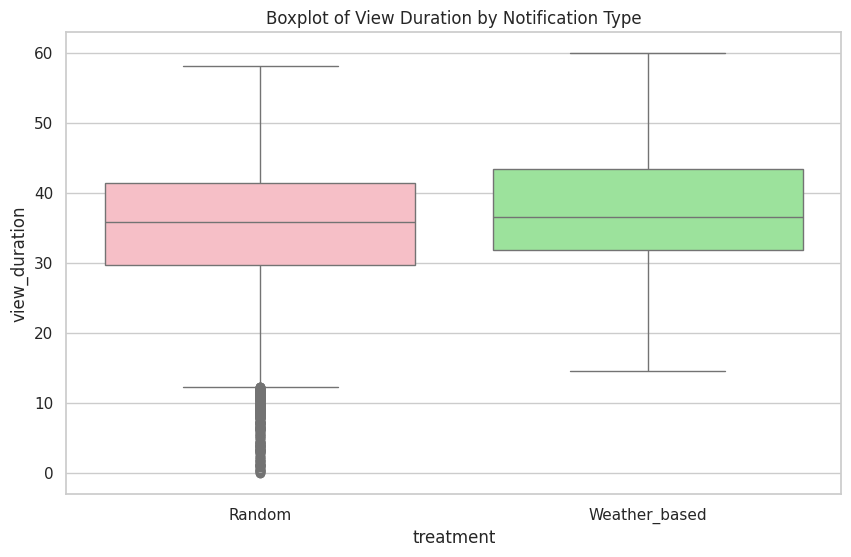

In [31]:
# Boxplots of View Duration by Notification Type
x_order = ['Random', 'Weather_based']

plt.figure(figsize=(10, 6))
sns.boxplot(x='treatment', y='view_duration', data=df, order=x_order, palette=['lightgreen', 'lightpink'], hue='treatment', dodge=False)

plt.title('Boxplot of View Duration by Notification Type')
plt.show()

In [32]:
df_control = df[df['treatment']=='Random']
df_treatment = df[df['treatment']=='Weather_based']

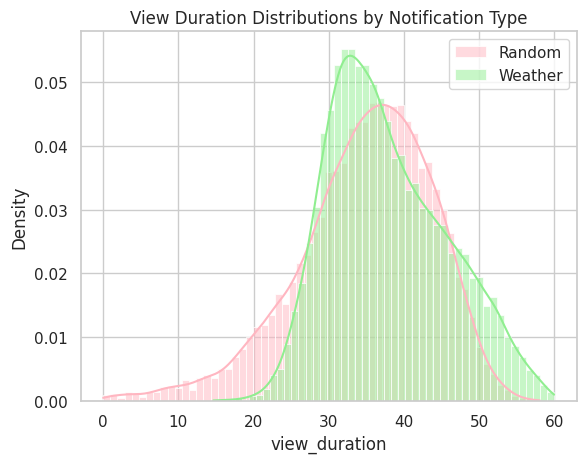

In [34]:
# View Duration Distributions by Notification Type
sns.histplot(df_control['view_duration'], color='lightpink', label='Random', kde=True, stat='density')
sns.histplot(df_treatment['view_duration'], color='lightgreen', label='Weather', kde=True, stat='density')
plt.legend()
plt.title('View Duration Distributions by Notification Type')
plt.show()

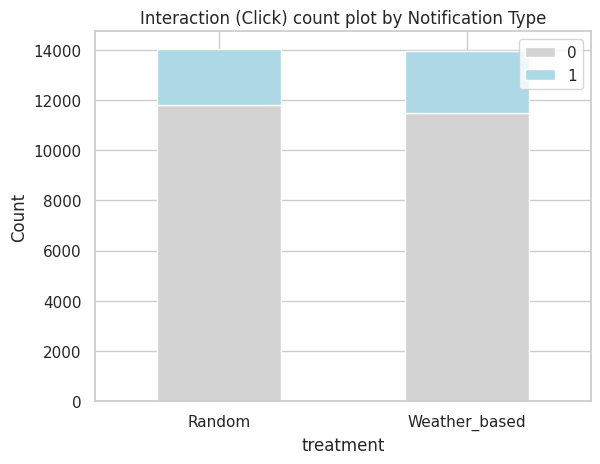

In [35]:
# Count of Interactions by Notification Type
count_data = df.groupby(['treatment', 'interaction']).size().unstack(fill_value=0)

# Create a stacked bar plot using the count data
count_data.plot(kind='bar', stacked=True, color=['lightgrey', 'lightblue'])

# Label the plot
plt.title('Interaction (Click) count plot by Notification Type')
plt.xlabel('treatment')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.legend(loc='upper right')

# Show the plot
plt.show()

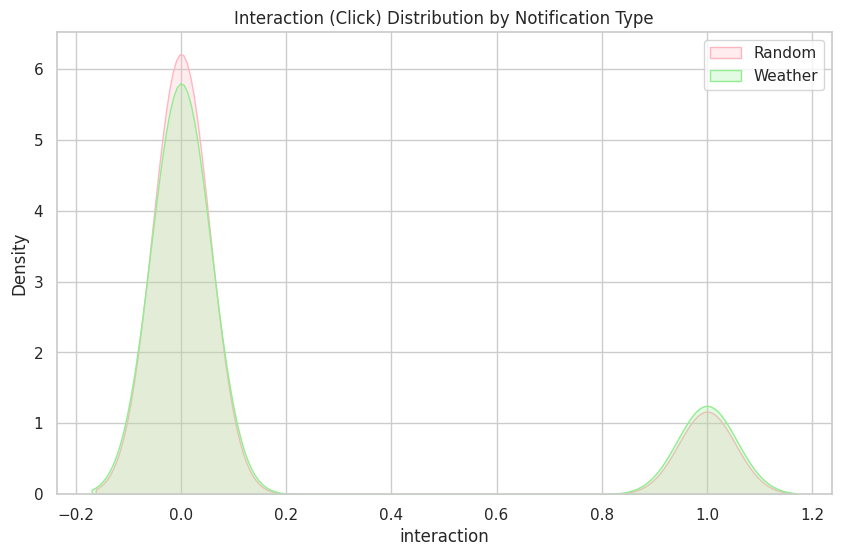

In [36]:
# Interaction Distribution by Notification Type
plt.figure(figsize=(10, 6))
sns.kdeplot(df_control['interaction'], label='Random', color='lightpink', fill=True)
sns.kdeplot(df_treatment['interaction'], label='Weather', color='lightgreen', fill=True)
plt.title('Interaction (Click) Distribution by Notification Type')
plt.legend()
plt.show()

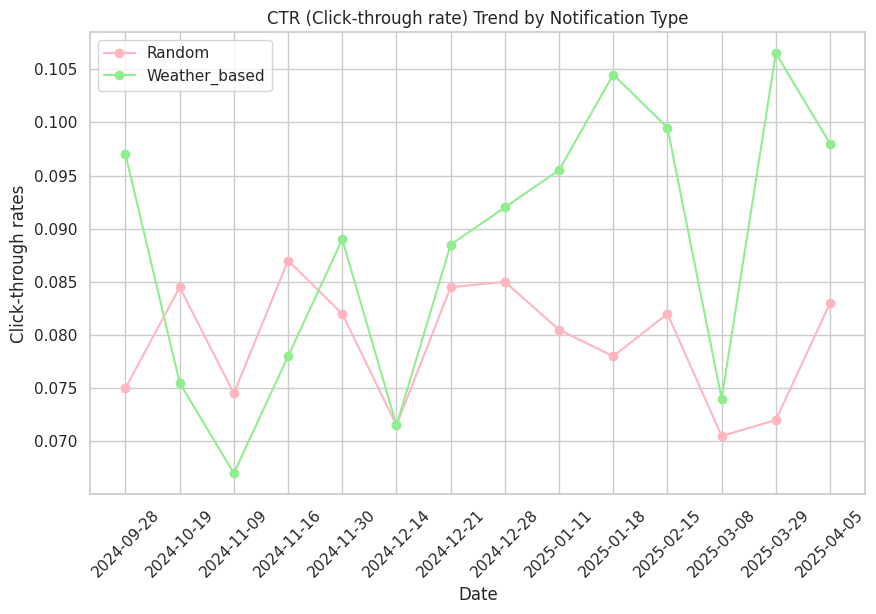

In [37]:
# CTR (Click-through rate) Trend by Notification Type
time_ctr_random = df_control.groupby('view_date')['interaction'].sum() / df.groupby('view_date')['interaction'].count()
time_ctr_weather = df_treatment.groupby('view_date')['interaction'].sum() / df.groupby('view_date')['interaction'].count()

plt.figure(figsize=(10, 6))
plt.plot(time_ctr_random.index, time_ctr_random, marker='o', color='lightpink', label='Random')
plt.plot(time_ctr_weather.index, time_ctr_weather, marker='o', color='lightgreen', label='Weather_based')

plt.title('CTR (Click-through rate) Trend by Notification Type')
plt.xlabel('Date')
plt.ylabel('Click-through rates')
plt.xticks(rotation=45)
plt.legend()



---


## 7. A/B Testing: Did the Treatment Increase Engagement?

We compare average **view duration** between:

- **Treatment group**: Weather-based notification
- **Control group**: Random notification

### 7.1. Assumption Checks

Before running a t-test, we verify its key assumptions:

- **Normality** of the distribution
- **Equal variances** — Are the spreads (standard deviations) similar across groups?

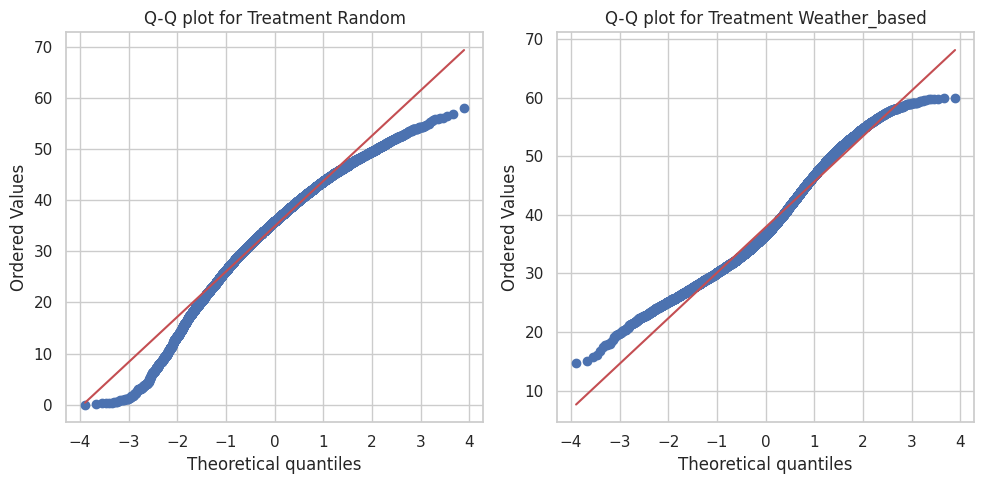

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
notifications = ['Random', 'Weather_based']

for i, notification in enumerate(notifications):
    ax = axes[i]
    stats.probplot(df[df['treatment'] == notification]['view_duration'], dist="norm", plot=ax)
    ax.set_title(f"Q-Q plot for Treatment {notification}")

plt.tight_layout()
plt.show()

In [39]:
#  Shapiro-Wilk test
from scipy.stats import shapiro

# H0: The data is normally distributed.
# H1: The data is normally distributed.

test_stat, pvalue = shapiro(df_control['view_duration'])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

test_stat, pvalue = shapiro(df_treatment['view_duration'])
print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 0.9730, p-value = 0.0000
Test Stat = 0.9757, p-value = 0.0000


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14035.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 13965.
  res = hypotest_fun_out(*samples, **kwds)


Although the Shapiro-Wilk test suggests that both groups follow a normal distribution, the Q-Q plots reveal noticeable deviations, indicating that the data may not be truly normally distributed.

In [43]:
# Levene's test for equality of variances
import scipy.stats as stats

# H0: the variance is equal across groups.
# H1: the variance is not equal across groups.

stat, p_value = stats.levene(df_control['view_duration'],
                             df_treatment['view_duration'])

print(f"Levene's test p-value = {p_value:.4f}")

Levene's test p-value = 0.0000


Levene’s test indicates a significant difference in variances, allowing us to reject the null hypothesis of equal variances between the groups.

Given the violations of normality and homogeneity of variances, we proceed with Welch’s t-test, which is more robust under these conditions.

### 7.2. One-Sided Welch's t-test

We aim to test whether **weather-based notifications** (treatment) lead to higher user engagement (measured by view duration) compared to random notifications (control).

- **Null Hypothesis (H₀):**  
  The mean view duration of the treatment group is **less than or equal to** that of the control group.  
  _μₜ ≤ μ꜀_

- **Alternative Hypothesis (H₁):**  
  The mean view duration of the treatment group is **greater than** that of the control group.  
  _μₜ > μ꜀_

In [46]:
# Welch's t-test
from scipy.stats import ttest_ind

# Display group means
print("Control Mean:", df_control['view_duration'].mean())
print("Treatment Mean:", df_treatment['view_duration'].mean())

# Perform Welch's t-test with one-sided alternative hypothesis
_, p = ttest_ind(
    df_treatment['view_duration'],
    df_control['view_duration'],
    equal_var=False,
    alternative='greater'  # testing if treatment > control
)

# Output p-value
print(f'p-value (one-sided, treatment > control) = {p:.4f}')


Control Mean: 34.89636042511228
Treatment Mean: 37.87534541438723
p-value (one-sided, treatment > control) = 0.0000


Welch’s t-test suggests that we can reject the null hypothesis and conclude that the treatment group has a significantly higher average view duration than the control group.

But is that the full story, or could other factors be influencing the result?



---


## 8. Causal Inference: Propensity Score Matching

### 8.1. Identifying Confounders

Here’s the dilemma: what if the weather-based recommendations just happened to feature more appealing content?

This is where **causal inference** comes in. It helps us isolate the effect of the treatment from confounding variables.

A **confounding variable (confounder)** is a variable that:

1. Influences the **treatment assignment** (e.g., certain content types are more likely to be shown on rainy days),
2. And also affects the **outcome** (e.g., more engaging content increases view duration).

We use **Propensity Score Matching (PSM)** to simulate what would’ve happened if users in both groups had the same baseline characteristics.

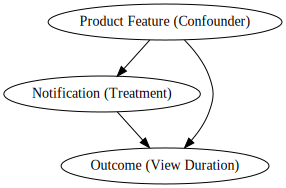

In [47]:
import graphviz as gr

g = gr.Digraph()

g.edge("Product Feature (Confounder)", "Notification (Treatment)")
g.edge("Product Feature (Confounder)", "Outcome (View Duration)")
g.edge("Notification (Treatment)", "Outcome (View Duration)")
g

In [48]:
df.groupby('product_feature')['view_duration'].mean()

,view_duration
product_feature,
N/A,34.867165
Rain,43.278335
Snow,37.009311
Sunny,32.474830


In [49]:
# Handle the categorical variable 'product_feature'

df['product_dummy'] = df['product_feature'].copy()
df = pd.get_dummies(df, columns=['product_dummy'], drop_first=False)

df[['product_dummy_Rain',	'product_dummy_Snow',	'product_dummy_Sunny', 'product_dummy_N/A']] = df[['product_dummy_Rain',	'product_dummy_Snow',	'product_dummy_Sunny', 'product_dummy_N/A']].astype(int)

### 8.2. Estimating Propensity Scores

We use logistic regression to model:

> **P(Treatment | Confounder)**

This gives us each user’s probability of being assigned to the treatment group, based on their features. That’s their **propensity score**.

In [50]:
# Choose features for propensity score calculation
X = df[['product_dummy_Rain',	'product_dummy_Snow',	'product_dummy_Sunny', 'product_dummy_N/A']]
y = df['treatment']

In [52]:
# Use logistic regression to calculate the propensity scores
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X, y)

LogisticRegression()

In [53]:
# Get the coefficients
lr.coef_.ravel()

array([ 2.30823827,  1.37940525,  2.27376479, -6.64515324])

In [54]:
# Combine features and coefficients into a dataframe
coeffs = pd.DataFrame({
    'column':X.columns.to_numpy(),
    'coeff':lr.coef_.ravel(),
})
coeffs

,column,coeff
0,product_dummy_Rain,2.308238
1,product_dummy_Snow,1.379405
2,product_dummy_Sunny,2.273765
3,product_dummy_N/A,-6.645153


These coefficients confirm that product type plays a major role in determining treatment assignment. For example, Rain-themed products are associated with a large increase in the log-odds of receiving a weather-based notification compared to the baseline.

In [55]:
# Prediction
pred_binary = lr.predict(X)
pred_prob = lr.predict_proba(X)  # probabilities for classes

In [56]:
import math

# The propensity score (ps) is the probability of being 1 (i.e., in the treatment group)
df['ps'] = pred_prob[:, 1]

<Axes: xlabel='ps', ylabel='Count'>

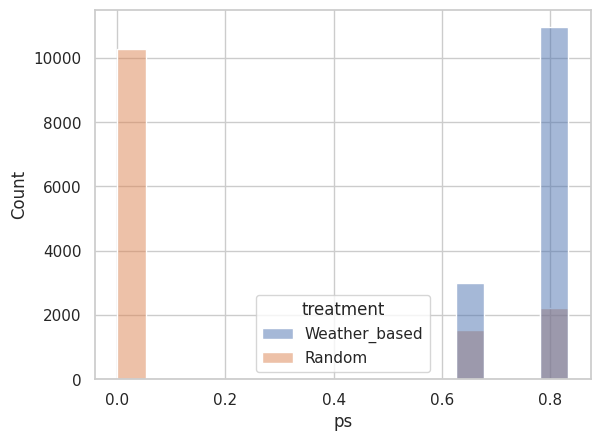

In [57]:
# Plot the histogram of propensity scores for both control and treatment groups
# If there is no overlap in the scores, matching will not be effective.
sns.histplot(data=df, x='ps', hue='treatment')

Since products with the 'product_feature_N/A' category were not included in the "Weather_based" treatment group, there are no matching propensity scores for this feature.

### 8.3. Nearest Neighbor Matching

Using the propensity scores, we match each treated session with a control session that had a similar probability of being treated — but wasn’t.

Since our propensity score distribution is relatively limited, we apply a simple K-nearest neighbors (KNN) with K=1 matching approach without using a caliper.

This creates balanced “twins” across treatment and control sessions, eliminating bias from covariate imbalances.

In [59]:
from sklearn.neighbors import NearestNeighbors

# Separate treated and control
treated = df[df['treatment'] == 'Weather_based']
control = df[df['treatment'] == 'Random']

# Fit Nearest Neighbor on control group
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['ps']])

# Match each treated unit to nearest control unit
distances, indices = nn.kneighbors(treated[['ps']])

# Get matched pairs
matched_controls = control.iloc[indices.flatten()].copy()
matched_treated = treated.reset_index(drop=True)

# ombine into one matched dataset
matched_controls.reset_index(drop=True, inplace=True)
matched_data = pd.concat([matched_treated, matched_controls], axis=1, keys=["treated", "control"])

# Flatten multi-level columns
matched_data.columns = ['_'.join(col).strip() for col in matched_data.columns.values]

print(f"Total matched pairs: {len(matched_data)}")
matched_data.head()

Total matched pairs: 13965


,treated_notification_id,treated_user_id,treated_notification_datetime,treated_treatment,treated_product_id,treated_interaction,treated_view_duration,treated_view_datetime,treated_view_date,treated_product_released_date,...,control_min_temp,control_avg_temp,control_condition,control_precipitation,control_simplified_condition,control_product_dummy_N/A,control_product_dummy_Rain,control_product_dummy_Snow,control_product_dummy_Sunny,control_ps
0,1,87,2025-04-05 15:00:00,Weather_based,83,1,42.698244,2025-04-05 19:58:25,2025-04-05,2023-05-07,...,-2.1,0.5,Sunny,0.0,Sunny,0,1,0,0,0.833428
1,6,87,2025-01-11 15:00:00,Weather_based,223,0,33.139315,2025-01-11 17:03:35,2025-01-11,2023-04-30,...,-0.4,2.9,Moderate rain at times,2.1,Rain,0,0,1,0,0.664026
2,9,87,2024-12-14 15:00:00,Weather_based,275,1,27.682671,2024-12-14 15:33:25,2024-12-14,2024-06-08,...,17.7,19.5,Moderate or heavy rain shower,13.7,Rain,0,0,0,1,0.828587
3,12,87,2024-11-09 15:00:00,Weather_based,428,0,37.301984,2024-11-09 19:28:58,2024-11-09,2024-04-22,...,17.7,19.5,Moderate or heavy rain shower,13.7,Rain,0,0,0,1,0.828587
4,1,525,2025-04-05 15:00:00,Weather_based,123,0,52.893922,2025-04-05 17:10:39,2025-04-05,2023-04-30,...,-2.1,0.5,Sunny,0.0,Sunny,0,1,0,0,0.833428


In [60]:
print('total observations in treatment:', len(df[df.treatment=='Weather_based']))
print('total observations in control:', len(df[df.treatment=='Random']))
print('total matched observations:', len(matched_data))

total observations in treatment: 13965
total observations in control: 14035
total matched observations: 13965


### 8.4. One-Sided Welch's t-test After PSM

After matching the sessions, we re-run the t-test.

At this stage, the treatment and control groups are comparable in all aspects except for the treatment itself. This allows us to interpret any observed differences in engagement as a more reliable causal effect of the notification strategy.

In [61]:
matched_control = matched_data['control_view_duration']
matched_treatment = matched_data['treated_view_duration']

In [64]:
# Welch's t-test

# Display group means
print("Control Mean:", matched_control.mean())
print("Treatment Mean:", matched_treatment.mean())

# Perform Welch's t-test with one-sided alternative hypothesis
_, p = ttest_ind(
    matched_treatment,
    matched_control,
    equal_var=False,
    alternative='greater'  # testing if treatment > control
)

# Output p-value
print(f'p-value (one-sided, treatment > control) = {p:.4f}')

Control Mean: 38.131168409919056
Treatment Mean: 37.87534541438723
p-value (one-sided, treatment > control) = 0.9946


The p-value is 0.9946, indicating we fail to reject the null hypothesis and there is no significant evidence that the treatment (weather-based notifications) results in a higher view duration compared to the control group (random notifications).

In the pre-PSM t-test, we observed a significant difference in means between the treatment and control groups. However, after applying PSM, we see that the difference in means has disappeared. This suggests that the initial observed effect was likely due to confounder -- **the difference in view duration observed initially was mainly due to the different product features shown to the users, rather than the notification strategy**.

### 8.5. Estimating the Average Treatment Effect (ATE)

Finally, we estimate the **causal effect size**:

> **ATE = Mean(View Duration | Treatment) – Mean(View Duration | Control)**

This tells us how much extra engagement we can expect purely due to weather-based notification — **not** content appeal.


In [66]:
# Pre-PSM

control_vals = df[df['treatment'] == 'Random']['view_duration']
treated_vals = df[df['treatment'] == 'Weather_based']['view_duration']

pooled_std = np.sqrt((treated_vals.std(ddof=1) ** 2 + control_vals.std(ddof=1) ** 2) / 2)
cohen_d_before_matching = (treated_vals.mean() - control_vals.mean()) / pooled_std

print(f"Cohen's d (before matching) = {cohen_d_before_matching:.4f}")

Cohen's d (before matching) = 0.3529


In [67]:
# Post-PSM

control_vals = matched_data['control_view_duration']
treated_vals = matched_data['treated_view_duration']

pooled_std = np.sqrt((treated_vals.std(ddof=1) ** 2 + control_vals.std(ddof=1) ** 2) / 2)
cohen_d_after_matching = (treated_vals.mean() - control_vals.mean()) / pooled_std

print(f"Cohen's d (after matching) = {cohen_d_after_matching:.4f}")

Cohen's d (after matching) = -0.0305


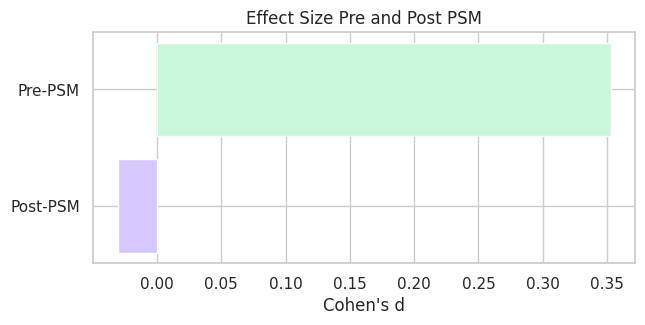

In [69]:
# Effect size change before and after matching

labels = ['Post-PSM', 'Pre-PSM']
effect_sizes = [cohen_d_after_matching, cohen_d_before_matching]
colors = ['#D6C8FF', '#C8F7DC']

plt.figure(figsize=(7, 3))
plt.barh(labels, effect_sizes, color=colors)
plt.xlabel("Cohen's d")
plt.title("Effect Size Pre and Post PSM")

plt.show()



---


## 9. Results and Interpretation

Let’s summarize what we found.

### Observation from A/B Test:
- Users in the treatment group **watched videos significantly longer** than those in the control group.

### But... Causal Inference Says:
- After controlling for the confounder, **product appeal**, the treatment effect disappears.
- The increased engagement was **not due to weather-based notifications**, but because the **recommended products** in the treatment group happened to be more appealing.

### Key Takeaway:
> Just because something worked, doesn’t mean it worked **because** of what you think.

If we had launched this feature based on the A/B test alone, we’d be misattributing the success — and possibly investing in the wrong strategy.



---



## 10. Future Directions

### 10.1. Analyze Guardrail Metrics and Tracking metrics

While our analysis focused on **view duration** as the primary engagement metric, it's crucial to think more broadly about user behavior and long-term platform health.

**Guardrail metrics** help us avoid negative side effects, even when our primary metric improves.

- **Notification Fatigue**: Are users receiving too many push notifications, leading to frustration or annoyance?
- **Opt-Out Rate**: Are more users choosing to disable notifications after being overwhelmed by frequent alerts?

**Tracking metrics** capture user behavioral signals that help us understand why engagement may rise or fall.

- **Click-Through Rate (CTR)**: Are users more likely to tap on the weather-based notification compared to random ones?
- **Time to First Engagement**: How quickly do users respond after receiving the notification?
- **Bounce Rate**: Do users drop off sooner after clicking certain types of notifications?

### 10.2. Explore Alternative Causal Inference Methods

While Propensity Score Matching is effective, it's just one approach. Other causal inference methods like **Difference-in-Differences (DiD)** and **Instrumental Variables (IV)** offer deeper analysis.

**DiD** is ideal when we have pre- and post-treatment data for both groups. It isolates the treatment effect by comparing changes over time, controlling for external trends (e.g., app updates).

> DiD Estimate = (Post - Pre in Treatment Group) - (Post - Pre in Control Group)

**IV** helps when treatment assignment may be influenced by unobserved factors. A valid instrument (e.g., sudden weather changes not predicted by the user) can help estimate unbiased treatment effects.